# Making METARS into station plots

![MetPy logo](https://unidata.github.io/MetPy/latest/_static/metpy_horizontal.png "MetPy")

This exercise introduces you to <a href = "https://www.unidata.ucar.edu/software/metpy/">MetPy</a>. MetPy is a Python package composed of modules for doing different meteorological calculations and generating publication-quality plots. MetPy is maintained by the University Corporation for Atmospheric Research (the same place that makes the MetEd modules), and accepts contribution of code from users. You can read more about MetPy at the above link, or peruse examples of nice plots you can make with MetPy <a href = "https://unidata.github.io/python-training/gallery/gallery-home/">here</a>.

MetPy is readily addable to most Python 3 distribution with a few dependencies. I've already included MetPy in this kernel for you, so you don't have to monkey with installation. (You're welcome!)

# <span style="color:red">Text in red indicates something you need to do on your own.</span>

### As with many Python packages, MetPy is composed of modules for reading in data performing calculations, and creating derived products (like images and files). 
Doubtless you will encounter MetPy in your future courses. Best to make friends with it!

Let's use a function in the "io" module called parse_metar_to_dataframe. (In computer science parlance, "I/O" stands for "input/output".) It takes a raw METAR and breaks it up into a Pandas DataFrame object.

## First, let's parse a single METAR into a dataframe.
In this case, it's a string copied straight from the FAA ASOS web site:
# KLAF 201154Z 13006KT 2 1/2SM +RA BR FEW015 BKN029 OVC039 21/20 A2998 RMK AO2 SLP148 P0005 60016 70016 T02060200 10222 20206 56008 $

We can see there is heavy rain at KLAF, temperature is 21 deg C, the dew point is 20 deg C, overcast skies at 39,000 feet, and sea level pressure of 1014.8 mb. Let's take a moment to sketch out how this station plot will look on the board.

Now that that's done, let's import some needed modules and functions.

In [7]:
from metpy.io import parse_metar_to_dataframe
from metpy.plots import add_metpy_logo, current_weather, sky_cover, StationPlot
import matplotlib.pyplot as plt
%matplotlib inline

### In the call to parse_metar_to_dataframe, I added two arguments: <b>year</b> and <b>month</b>. 
Recall that METARs don't include year and month in their default format. If you omit these arguments, MetPy assumes that the METAR is from the current year and month. If this isn't true, you need to override these values by explictly specifying them in the call to parse_metar_to_dataframe().

In [8]:
# Because raw METARs can be quite long, let's store one to a string variable.
myMETAR = "KLAF 201154Z 13006KT 2 1/2SM +RA BR FEW015 BKN029 OVC039 21/20 A2998 RMK AO2 SLP148 P0005 60016 70016 T02060200 10222 20206 56008 $"
data = parse_metar_to_dataframe(myMETAR, year = 2021, month = 9)
data # Print out the contents of the DataFrame

,station_id,latitude,longitude,elevation,date_time,wind_direction,wind_speed,visibility,current_wx1,current_wx2,...,air_temperature,dew_point_temperature,altimeter,current_wx1_symbol,current_wx2_symbol,current_wx3_symbol,remarks,air_pressure_at_sea_level,eastward_wind,northward_wind
station_id,,,,,,,,,,,,,,,,,,,,,
KLAF,KLAF,40.42,-86.93,182,2021-09-20 11:54:00,130,6.0,4023.36,+RA,BR,...,21.0,20.0,29.98,65,10,0,AO2 SLP148 P0005 60016 70016 T02060200 10222 2...,1015.05,-4.596267,3.856726


## Note that the DataFrame contains more information than the actual METAR. 
For example, where did the latitude, longitude, and elevation of the station come from? That's not in the METAR! MetPy has a lookup table containing a reasonably current list of ASOS sites around the world, and their corresponding coordinates. 

Additionally, MetPy has considerately calculated the u- and v-components of the wind for you. Scroll all the way to the right to see eastward_wind (u) and northward_wind (v) fields.

## For my next trick, I'll turn this METAR into a surface station plot.
I'll create a function definition in Python that takes the DataFrame object "data" and draws the station plot on a blank canvas.

A function definition is useful if you have a bunch of commands that you execute together, over and over, that take the same argument(s).

Note: Some of this code is sourced from https://unidata.github.io/MetPy/latest/examples/plots/Station_Plot.html

In [9]:
def draw_station_plot(data):
    """
    Draws a station plot from a Dataframe.
    
    Inputs:
    
        data: An Pandas Dataframe produced from metpy.io.parse_metar_into_dataframe().
        
    Outputs:
    
        A station plot floating on a small canvas.
    
    """
    # First, I have to create a figure and axis for the station plot to be drawn on.
    fig = plt.figure(figsize=(3, 3)) # make a 3-inch by 3-inch canvas
    ax = fig.add_subplot(1, 1, 1) # Make an axis called "ax" on the figure canvas

    # The following creates an instance of a StationPlot class at coordinates (0,0) on the canvas. 
    
    # Note: The actual station plot is not drawn until we use a couple of additional commands, below this one.
    # You can comment out each block to see what each one does.
    stationplot = StationPlot(ax, 0, 0, fontsize = 24)
    
    # Plot the temperature and dew point to the upper and lower left, respectively, of
    # the center point. Each one uses a different color.
    stationplot.plot_parameter('NW', data['air_temperature'].values, color='darkblue')
    stationplot.plot_parameter('SW', data['dew_point_temperature'].values, 
                               color='darkgreen')
    # A more complex example uses a custom formatter to control how the sea-level pressure
    # values are plotted. This uses the standard trailing 3-digits of the pressure value
    # in tenths of millibars.
    stationplot.plot_parameter('NE', data['air_pressure_at_sea_level'].values,
                               formatter=lambda v: format(10 * v, '.0f')[-3:])
    
    # Plot the cloud cover symbols in the center location. This uses the codes made above and
    # uses the `sky_cover` mapper to convert these values to font codes for the
    # weather symbol font.
    stationplot.plot_symbol('C', data['cloud_coverage'].values, sky_cover)
    # Same this time, but plot current weather to the left of center, using the
    # `current_weather` mapper to convert symbols to the right glyphs.
    stationplot.plot_symbol('W', data['current_wx1_symbol'].values, current_weather)
    
    # Add wind barbs
    stationplot.plot_barb(data['eastward_wind'].values, data['northward_wind'].values)
    
    # Also plot the actual text of the station id. Instead of cardinal directions,
    # plot further out by specifying a location of 2 increments in x and 0 in y.
    stationplot.plot_text((2, 0), data['station_id'].values)
    
    # These last lines remove the axes and ticks.
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

Nothing happens when you execute the block above; it's just defining the function draw_station_plot(). Now, we can actually use it:

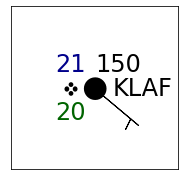

In [10]:
draw_station_plot(data)

## Wait a minute. The METAR said the sea level pressure is 148 mb. Why did it show up as 150 mb on the station plot?
Great question! Remember that SLP isn't always included in METARs, but altimeter setting is. Under the hood, MetPy does a quick conversion of the altimeter setting to a sea level pressure. It might be off by a few mb as a result.

# Your turn!
## <span style="color:red">1. Find a METAR from somewhere, historical or current.</span>
Suggestions: 
1. Hit up the <a href = "https://www.faa.gov/air_traffic/weather/asos">FAA ASOS site</a> and find an ASOS that's reporting something moderately interesting. 
2. Iowa State has a database of <a href = "https://mesonet.agron.iastate.edu/ASOS/recent.phtml">recent interesting METARs</a> (e.g., tornado reports).
3. You can also search the web for METARs associated with historical weather events from the 1970s onward.

### <span style="color:red">Once you've found your METAR, copy and paste it in between the quotation marks below.</span>

In [ ]:
myMETAR2 = "" # Paste your METAR in between the quotation marks!

# Note: If your METAR is historical, you will need to change the year and month!
data2 = parse_metar_to_dataframe(myMETAR2, year = 2021, month = 9)
data2 # Print out the contents of the DataFrame

# <span style="color:red">2. Draw the station plot by hand.</span>
As a reminder, here is the <a href= "https://www.wpc.ncep.noaa.gov/html/stationplot.shtml">NWS tutorial</a> on how to decode station plots. Here's another <a href = "https://www.aviationweather.gov/metar/symbol">similar chart</a>.

If, by chance, your weather symbol isn't included on the sites above, there is a frighteningly complete list of them on pages 274--279 of <a href = "https://www.eoas.ubc.ca/books/Practical_Meteorology/prmet102/Ch09-wxmaps-v102b.pdf">Ch. 9</a> of Practical Meteorology by Roland Stull.

# <span style="color:red">3. Copy-and-paste your METAR and post your hand-drawn artwork on Slack.</span>

# <span style="color:red">4. Then, and only then, ask MetPy to draw it for you!</span>
Execute the code block below.

In [ ]:
draw_station_plot(data2)

# <span style="color:red">5. Add your MetPy station plot to your Slack post as a comment.</span>
Do they match?
Remember you can access our class slack through any browser via https://eaps227-2021.slack.com

# Moving on to maps...
All of the above was for plotting a single station. 
## What if we want to create several station plots on a map?

Note: Much of this portion of the notebook is based on the MetPy Monday video at this link:
https://youtu.be/Fa0tGT2PbIw

The <a href = "https://www.youtube.com/playlist?list=PLQut5OXpV-0ir4IdllSt1iEZKTwFBa7kO">MetPy Monday series</a> is fun. They have numerous tutorials on how to make custom and professional-looking meteorological plots and charts. I recommend subscribing!

We need to hook up to an online catalog that contains a current catalog of METARs. We'll use a MetPy-associated Python tool called siphon to do this.

In [ ]:
from siphon.catalog import TDSCatalog
cat = TDSCatalog("http://thredds-test.unidata.ucar.edu/thredds/catalog/noaaport/text/metar/")

### The siphon - catalog setup points your notebook to an online repository of METARs.
To see the current contents, click here: https://thredds-test.unidata.ucar.edu/thredds/catalog/noaaport/text/metar/catalog.html

Let's point to one particular METAR text file:

In [ ]:
ds = cat.datasets[-18]  # The number in front of the minus sign means "XX hours ago"
# Note that I decrement by a few hours, just to make sure the METAR text file is reasonably complete
ds # Print the name of the file to be downloaded

In [ ]:
ds.download()  # This actually downloads the specified text file

If you look in the directory in which this notebook is located, you'll see the file has appeared. Have a look at the contents.

## To actually see the contents of the data file, we need to import a different function from metpy.io called parse_metar_file().
This splits up a ginormous text file like this into a DataFrame.

In [ ]:
from metpy.io import parse_metar_file

df = parse_metar_file(ds)
df  # Print out the contents of the DataFrame to the screen

## Note the  number of rows (thousands). There are way too many METARs to plot at once!
## We need to dump some rows that don't contain the information we need to make station plots.
For example, if a row is missing air temperature, dew point, sea level pressure, then the station plotting function will crash.

## We use a built-in DataFrame function called "dropna" (which means "drop if not a number").
We drop any rows missing critical data. 

Note that we reassign the DataFrame object with dropped rows back to the variable df.

In [ ]:
df = df.dropna(subset = ['air_temperature', 'dew_point_temperature', 
                         'air_pressure_at_sea_level', 'cloud_coverage',
                         'current_wx1_symbol'], how = 'any')
df 

### The number of rows decreased by a few hundred. 
This confirms that rows missing information needed to make the station plots have been dropped.

## Next, we need to set up a map projection on which to plot the station plots. 
To do this, we'll use another package called <a href = "https://scitools.org.uk/cartopy/docs/latest/">CartoPy</a>. 

![CartoPy logo](https://scitools.org.uk/cartopy/docs/latest/_static/cartopy.png "CartoPy")

It can produce a wide variety of map projections. We'll use one called Lambert Conformal, which is pretty good for most purposes. 

In [ ]:
import cartopy.crs as ccrs
#import cartopy.feature as cfeature

# Set up the map projection
proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=35,
                             standard_parallels=[35])

# Use the Cartopy map projection to transform station locations to the map and
# then refine the number of stations plotted by setting a 300km radius
point_locs = proj.transform_points(ccrs.PlateCarree(), df['longitude'].values,
                                   df['latitude'].values)

# This DataFrame has way too many stations to plot all of them. 
# The number of stations plotted will be reduced using reduce_point_density.
from metpy.calc import reduce_point_density
from metpy.units import units
df = df[reduce_point_density(point_locs, 300. * units.km)]
df

# Actual map plotting:
This code has to be executed as one gigantic block.
## <span style="color:red">Please read through this block and make sure you understand what it is doing before executing.</span>

In [ ]:
# Change the DPI of the resulting figure. Higher DPI drastically improves the
# look of the text rendering.
plt.rcParams['savefig.dpi'] = 255

# Create the figure and an axes set to the projection.
fig = plt.figure(figsize=(20, 10))
add_metpy_logo(fig, 1100, 300, size='large')
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Set plot bounds (latitude and longitude)
ax.set_extent([-118, -73, 23, 50], crs=ccrs.PlateCarree())

# Add some various map elements to the plot to make it recognizable.
# Note: These features require "fetching" from an external site.
# Commands may fail if you don't have write permissions.
#ax.add_feature(cfeature.LAND)
#ax.add_feature(cfeature.OCEAN)
#ax.add_feature(cfeature.LAKES)
#ax.add_feature(cfeature.COASTLINE)
#ax.add_feature(cfeature.STATES)
#ax.add_feature(cfeature.BORDERS)
# Trust me, these look really nice when they work.

# Because the downloadable shapefiles are not working, 
# let's use a static one I've already installed on Scholar for you.
from cartopy.io.shapereader import BasicReader
countries = BasicReader('/depot/eapsdept/apps/eaps227-2021/gis/ne_110m_admin_0_countries.shp')
states = BasicReader('/depot/eapsdept/apps/eaps227-2021/gis/ne_110m_admin_1_states_provinces_lines.shp')

ax.add_geometries(countries.geometries(), ccrs.PlateCarree(), facecolor = 'none', edgecolor = 'black', lw = 2)
ax.add_geometries(states.geometries(), ccrs.PlateCarree(), facecolor = 'none', edgecolor = 'gray')

# Start the station plot by specifying the axes to draw on, as well as the
# lon/lat of the stations (with transform). We also change the fontsize to 12 pt.
stationplot = StationPlot(ax, df['longitude'].values, df['latitude'].values,
                          clip_on=True, transform=ccrs.PlateCarree(), fontsize=12)

# Plot the temperature and dew point to the upper and lower left, respectively, of
# the center point. Each one uses a different color.
stationplot.plot_parameter('NW', df['air_temperature'].values, color='darkblue')
stationplot.plot_parameter('SW', df['dew_point_temperature'].values,
                           color='darkgreen')

# A more complex example uses a custom formatter to control how the sea-level pressure
# values are plotted. This uses the standard trailing 3-digits of the pressure value
# in tenths of millibars.
stationplot.plot_parameter('NE', df['air_pressure_at_sea_level'].values,
                           formatter=lambda v: format(10 * v, '.0f')[-3:])

# Plot the cloud cover symbols in the center location. This uses the codes made above and
# uses the `sky_cover` mapper to convert these values to font codes for the
# weather symbol font.
stationplot.plot_symbol('C', df['cloud_coverage'].values, sky_cover)

# Same this time, but plot current weather to the left of center, using the
# `current_weather` mapper to convert symbols to the right glyphs.
stationplot.plot_symbol('W', df['current_wx1_symbol'].values, current_weather)

# Add wind barbs
stationplot.plot_barb(df['eastward_wind'].values, df['northward_wind'].values)

# Also plot the actual text of the station id. Instead of cardinal directions,
# plot further out by specifying a location of 2 increments in x and 0 in y.
stationplot.plot_text((2, 0), df['station_id'].values)

plt.title(df['date_time'][0])


plt.show()

## <span style="color:red">Try playing around with some of the parameters in the block above. For example, try changing the latitude/longitude limits, or colors of some of the elements.</span>